In [1]:
import os
import sys
import ogr
from gdalconst import *
import gdal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Create path to data directory, make sure it exists
data_dir = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir),"Data")
assert os.path.isdir

In [3]:
# Define paths to image file and shape files + make sure it exists
imgf = os.path.join(data_dir, "PDX_DEM_WGS84_UTM10N_Zm_INT16.tif")
assert os.path.isfile(imgf)

In [4]:
# Open the dataset
ds = gdal.Open(imgf, GA_ReadOnly)

In [5]:
# Check the projection info
ds.GetProjection()

# Get Geo-Transform
# Geotransform is the coordinates of the upper left pixel, the dx/dy for a pixel, and any rotational transform 
# 0  X Origin Coord
# 1  X pixel Width
# 2  X pixel rotation (0 degrees if north up)
# 3  Y Origin Coord
# 4  Y pixel rotation (0 degrees if north up)
# 5  Y pixel Height (negative)
# in the following order (ulx, dx, rx, uly, ry, dy)

ds.GetGeoTransform()

(490893.2197361471, 10.0, 0.0, 5054008.957242726, 0.0, -10.0)

In [6]:
# Determine how many bands the raster has
ds.RasterCount

1

In [7]:
# Get a specific raster band
band = ds.GetRasterBand(1)  # Counting for raster bands starts at 1... not 0...

In [8]:
# Turn the raster band into a numpy array
data = band.ReadAsArray()

In [20]:
# Get shape of array
r, c = data.shape
print(r, c)

3951 6161


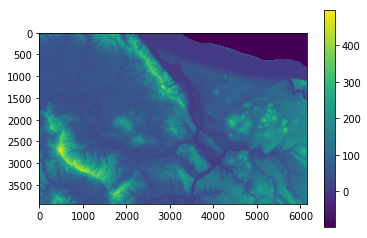

In [9]:
# Show the data
plt.imshow(data)
plt.colorbar()
plt.show()

In [10]:
# Find the highest value in the array
print(data.max())

497


In [31]:
# Find its location
mx_loc = np.argmax(data)
print(mx_loc)

16678298


In [32]:
# This returns the positional index of the flattened 2D array... 
# but it doesn't help us DIRECTLY locate the point in a 2D array, 
# to do so we need to do some math:

# To find row that mx_loc lives in, divide mx_loc by the number of columns in the array
# and take the floor of the float value
mx_r = np.floor(mx_loc/c)
print(mx_r)

2707.0


In [33]:
# Now that we know what row the value is, we need to subtract the rows*cols 
# from the index loc to determine the column location 
mx_c = mx_loc - (c * mx_r)
print(mx_c)

471.0


In [39]:
# Query the array using the calculated row/col indexes
print(data[mx_r, mx_c])

# Why doesn't this work

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [40]:
# You need to supply integers when indexing arrays
print(data[int(mx_r),int(mx_c)])

497


In [43]:
# You can also use a numpy function to do this... lets check our work:
np.unravel_index(np.argmax(data, axis=None), data.shape)

(2707, 471)

In [45]:
# Thats cool, but what if you wanted to know the value at a specific geographic location?
# Above we learned that the geo transform gives a starting location, and a step size 
# for projected imagery. Lets use the location of QSI to find the elevation of the earth at the office.

# Taken from Arc Base map - Same projection as imagery (WGS84 UTM10N Meters)
ox, oy = (525149.055,  5040856.528) 

In [46]:
# Store the geotransform 
gt = ds.GetGeoTransform()

In [47]:
# Find the offset from the origin for the x and y points
ox_off = ox - gt[0]
oy_off = oy - gt[3]
print(ox_off, oy_off)

34255.83526385296 -13152.429242726415


In [56]:
# Divide the offset by the step size to get row/col location
ox_c = ox_off/gt[1]
oy_r = oy_off/gt[5]
print(ox_c, oy_r)

3425.583526385296 1315.2429242726416


In [57]:
# Use calculated indexes to get office elevation
data[int(oy_r),int(ox_c)]

12

In [ ]:
# extract data from a bounding box